In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
avisos_detalle = pd.read_csv('~/orga-datos/datos_preprocesados/fiuba_6_avisos_detalle.csv')
# Estas columnas no aportan suficiente información
# idpais: Siempre vale 1
# ciudad: Hay alrededor de 50 registros con esta información, el resto es NaN
# mapacalle: Hay sólo 683 registros con esta información.
avisos_detalle = avisos_detalle.drop(axis=1, labels=['idpais', 'ciudad', 'mapacalle', 'titulo', 'descripcion', 'nivel_laboral', 'denominacion_empresa'])
avisos_detalle['nombre_zona'] = avisos_detalle['nombre_zona'].astype('category')
avisos_detalle = pd.get_dummies(avisos_detalle, columns=['nombre_zona', 'nombre_area', 'tipo_de_trabajo'])

In [6]:
postulantes = pd.read_csv('~/orga-datos/datos_procesados/vector_postulantes.csv') # Este archivo se genera en postulantes.py

In [5]:
postulaciones = pd.read_csv('~/orga-datos/tmp/set_entrenamiento.csv') # El set tiene filtrado que avisos se vieron y que avisos se postularon.
postulaciones = pd.merge(postulaciones, postulantes, on='idpostulante', how='inner')
postulaciones = postulaciones.drop(axis=1, labels=['idpostulante'])
postulaciones = postulaciones[postulaciones['sepostulo'] == 1]
postulaciones = postulaciones.drop(axis=1, labels=['sepostulo'])

In [6]:
avisos_postulantes_data = postulaciones.groupby('idaviso').agg('mean')
avisos_postulantes_data.head()

,sexo,edad,nivel_educativo
idaviso,,,
8725750,0.196721,31.434426,2.282787
12543760,-0.148674,29.317235,2.752367
12812680,-0.798658,24.610738,2.137584
17903700,-0.754717,33.490566,2.748428
1000132160,0.666667,37.833333,2.833333


In [7]:
avisos_detalle = avisos_detalle.set_index('idaviso')
avisos_detalle['edad'] = avisos_postulantes_data['edad']
avisos_detalle['sexo'] = avisos_postulantes_data['sexo']
avisos_detalle['nivel_educativo'] = avisos_postulantes_data['nivel_educativo']
avisos_detalle = avisos_detalle.reset_index('idaviso')

In [8]:
avisos_detalle.head()

#### Hasta acá: Generación de datos


#### Desde acá: Uso de resultados cacheados porque soy pobre y no tengo tanta RAM

In [31]:
avisos_detalle = pd.read_csv('/home/luciano/orga-datos/datos_procesados/avisos_mas_postulantes.csv')
avisos_detalle = pd.get_dummies(avisos_detalle, columns=['nombre_zona', 'nombre_area', 'tipo_de_trabajo'])

In [3]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(criterion='entropy', n_jobs=-1, verbose=1)

In [9]:
paso = 100000
total_lineas = 9560544
lineas_train = int(total_lineas * 0.9)
lineas_test  = int(total_lineas * 0.1)

CSV_POSTULACIONES = '/home/luciano/orga-datos/tmp/set_entrenamiento.csv'

for i in range(0, lineas_train, paso): # 9560544 = cantidad de lineas en set_entrenamiento.csv
    entrenamiento = pd.read_csv(CSV_POSTULACIONES, skiprows=range(1, i), nrows=paso)
    entrenamiento = pd.merge(entrenamiento, postulantes, on='idpostulante', how='inner')
    entrenamiento = pd.merge(entrenamiento, avisos_detalle, on='idaviso', how='inner')
    entrenamiento = entrenamiento.drop(axis=1, labels=['idaviso', 'idpostulante'])
    entrenamiento[entrenamiento['sexo_y'].isna()] = 0
    entrenamiento[entrenamiento['edad_y'].isna()] = 30
    y = entrenamiento['sepostulo']
    entrenamiento = entrenamiento.drop(axis=1, labels=['sepostulo'])
    rdf.fit(entrenamiento, y)

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Paral

In [11]:
scores = []
for i in range(lineas_train, total_lineas, paso):
    test = pd.read_csv(CSV_POSTULACIONES, skiprows=range(1, i), nrows=paso)
    test = pd.merge(test, postulantes, on='idpostulante', how='inner')
    test = pd.merge(test, avisos_detalle, on='idaviso', how='inner')
    test = test.drop(axis=1, labels=['idaviso', 'idpostulante'])
    test[test['sexo_y'].isna()] = 0
    test[test['edad_y'].isna()] = 30
    y = test['sepostulo']
    test = test.drop(axis=1, labels=['sepostulo'])
    scores.append(rdf.score(test, y))
    print(scores[-1])

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.95501


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7248934936096165


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7249117473524206


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.72287


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7242644852897058


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7206460323016151


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7212644252885058


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7202516075482265


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


0.7229716891506746
0.7246405252078353


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [50]:
CSV_TEST = '/home/luciano/orga-datos/test_final_100k.csv'
test_o = pd.read_csv(CSV_TEST)
test = pd.merge(test_o, postulantes, on='idpostulante', how='left')
test = pd.merge(test, avisos_detalle, on='idaviso', how='left')
test = test.drop(axis=1, labels=['id', 'idaviso', 'idpostulante'])
test[test['sexo_y'].isna()] = 0
test[test['edad_y'].isna()] = 30
test[test['sexo_x'].isna()] = 0
test[test['edad_x'].isna()] = 30
test[test['nivel_educativo_x'].isna()] = 0
ret = rdf.predict_proba(test)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


In [53]:
test_o['sepostulo'] = pd.DataFrame(ret)[1]

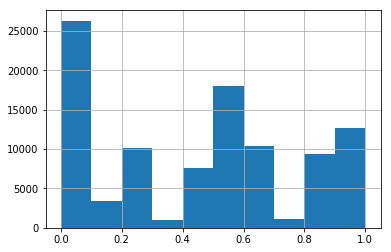

In [55]:
test_o['sepostulo'].hist()